<a href="https://colab.research.google.com/github/Rohithb97/DesignOptimization2021Fall/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 178.095


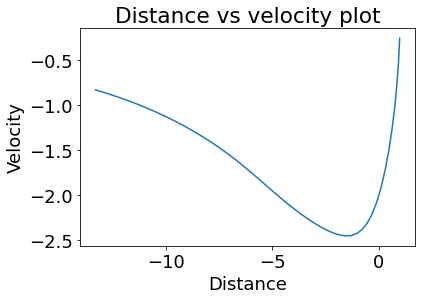

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 63.690


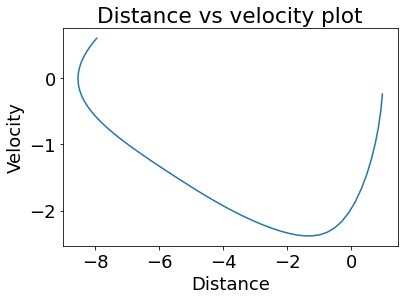

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 34.869


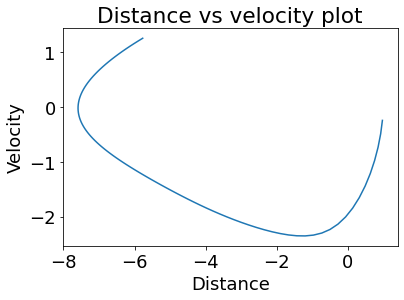

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 23.302


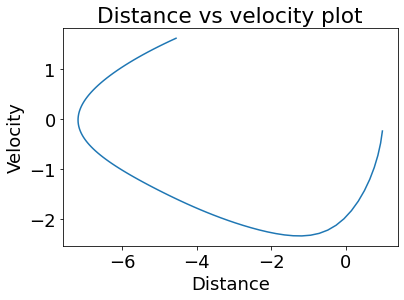

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 17.021


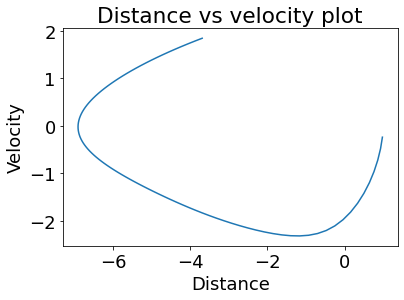

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 13.259


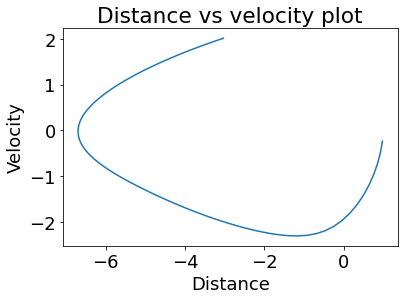

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 10.860


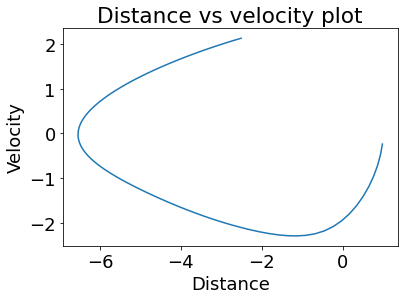

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 9.233


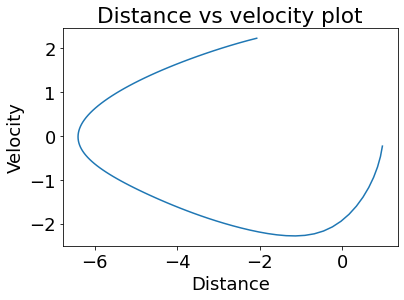

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 8.050


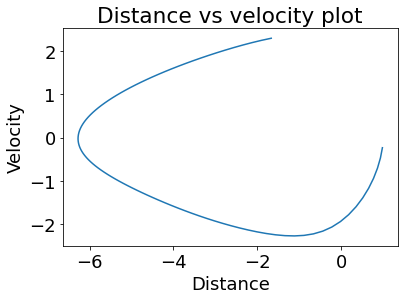

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 7.088


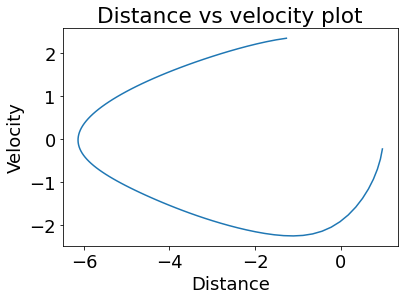

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 5.227


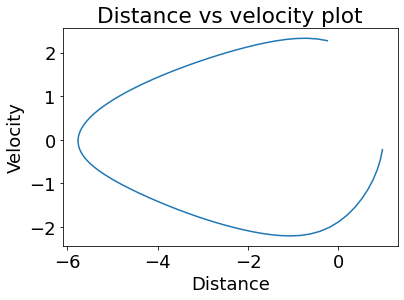

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 2.478


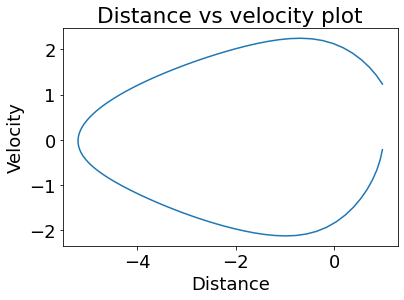

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 2.052


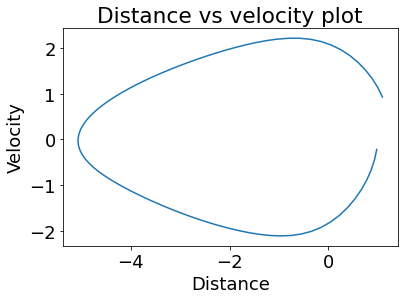

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 1.717


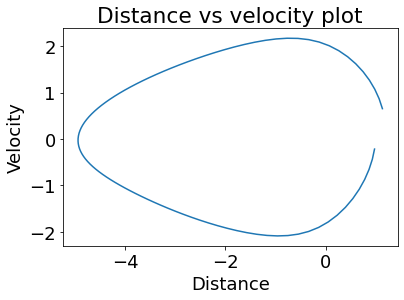

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 1.449


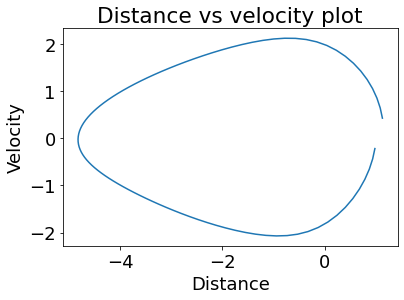

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 1.220


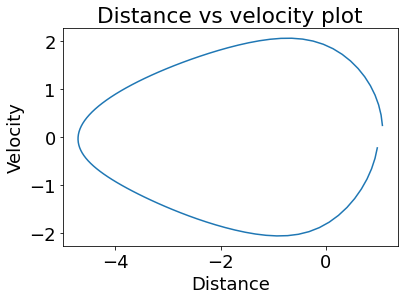

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 0.974


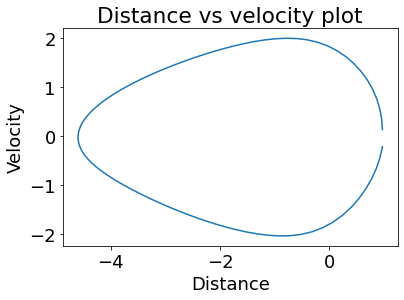

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 0.663


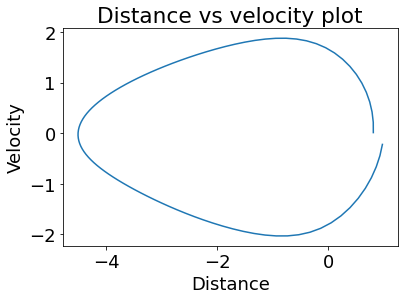

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 0.461


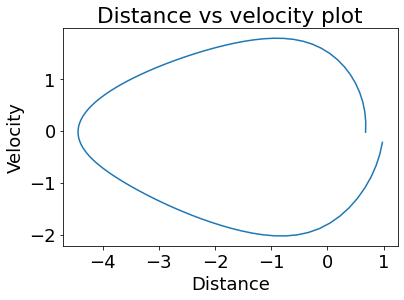

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 0.310


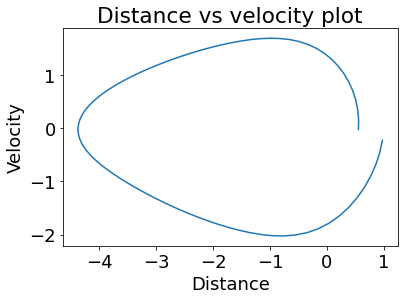

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 0.199


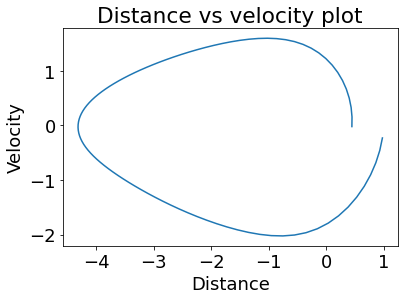

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 0.114


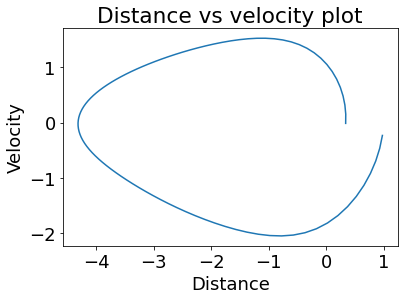

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 0.065


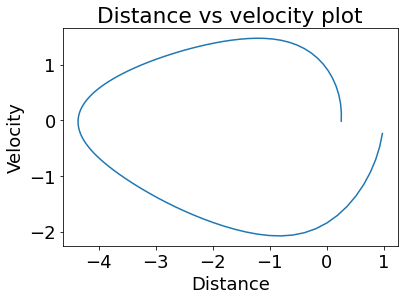

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 0.040


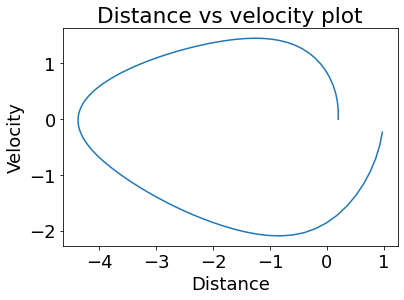

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 0.024


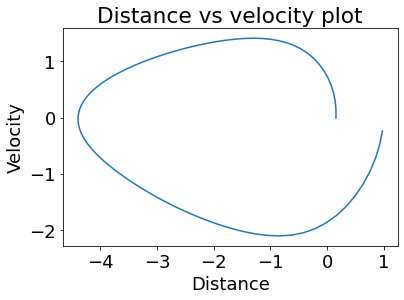

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 0.015


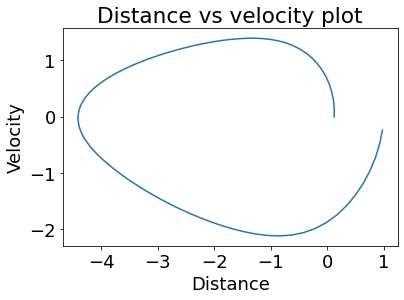

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 0.009


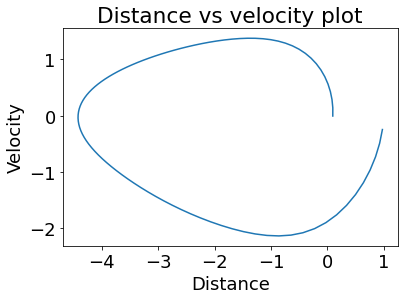

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 0.006


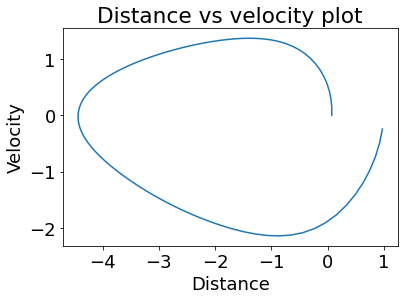

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 0.003


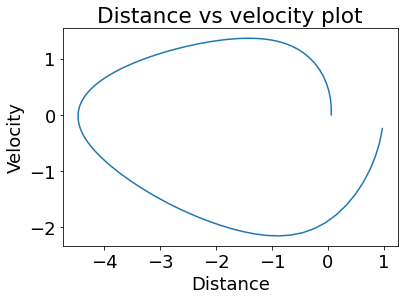

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 0.002


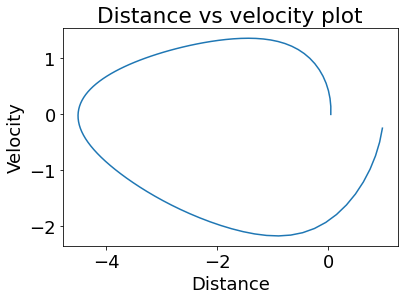

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 0.001


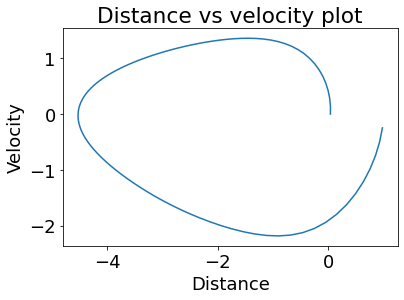

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 0.001


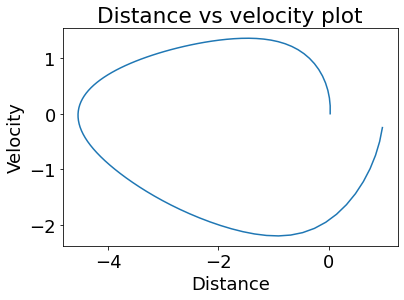

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 0.000


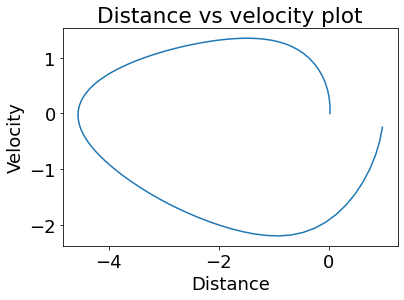

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 0.000


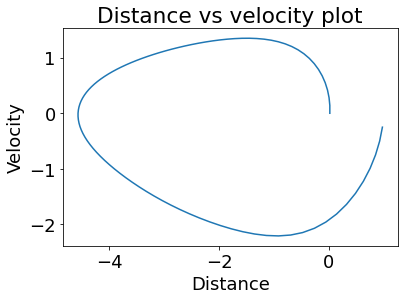

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 0.000


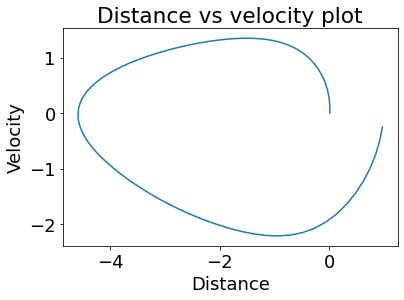

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 0.000


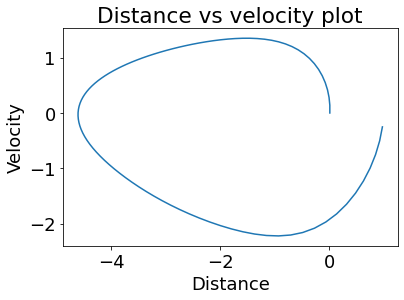

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.000


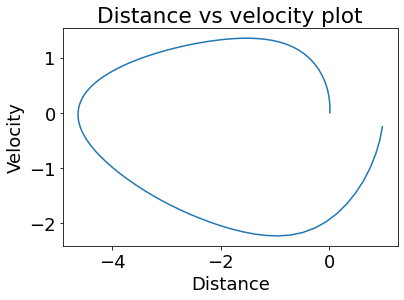

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.000


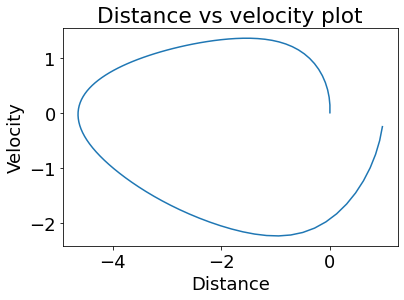

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.000


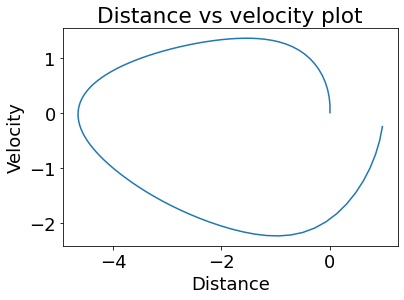

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.000


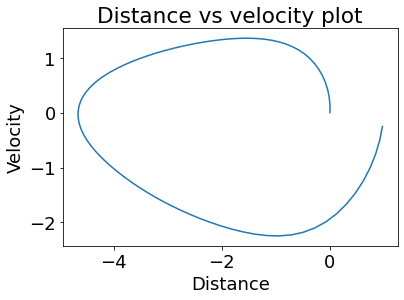

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.000


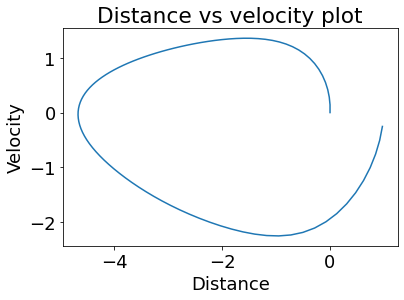

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.000


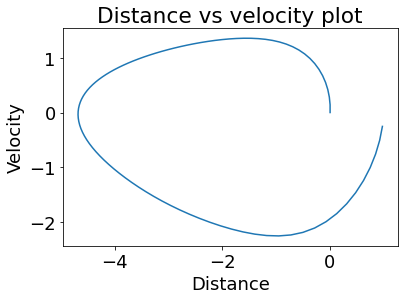

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.000


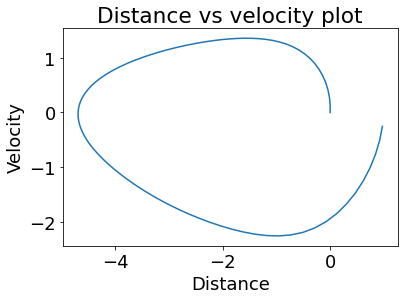

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.000


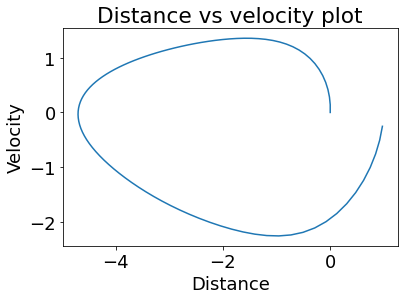

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.000


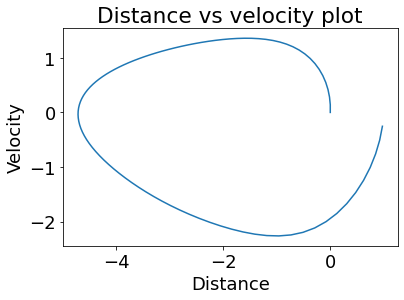

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.000


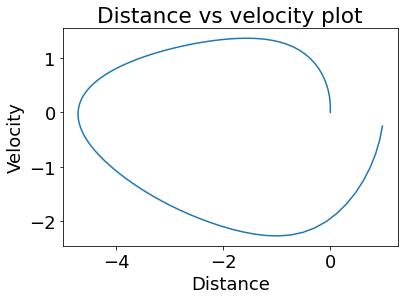

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.000


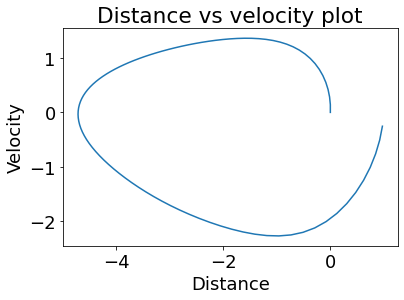

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.000


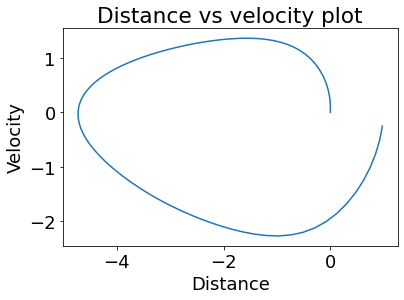

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.000


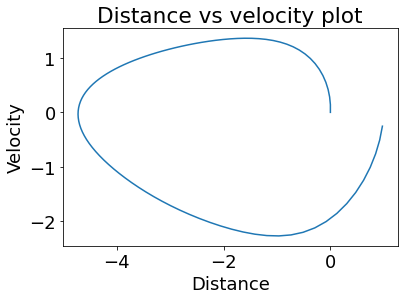

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.000


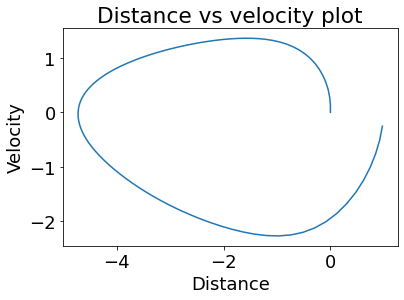

_______________________________________________________________________________________________________________

Iteration number:	 51
loss: 0.000


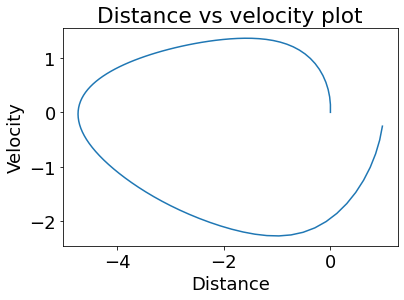

_______________________________________________________________________________________________________________

Iteration number:	 52
loss: 0.000


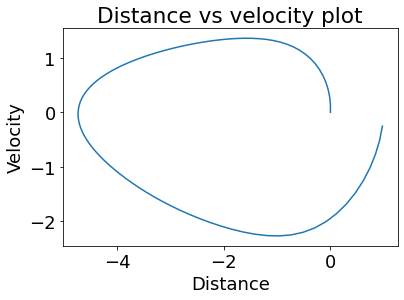

_______________________________________________________________________________________________________________

Iteration number:	 53
loss: 0.000


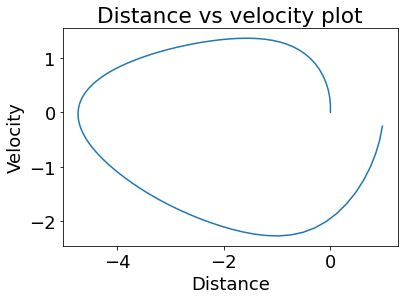

_______________________________________________________________________________________________________________

Iteration number:	 54
loss: 0.000


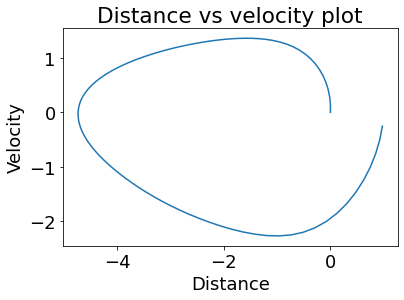

_______________________________________________________________________________________________________________

Iteration number:	 55
loss: 0.000


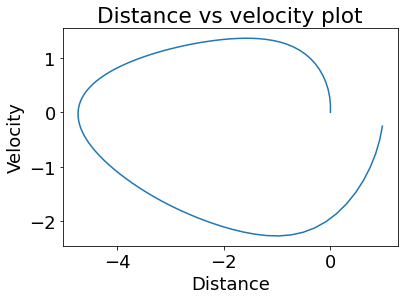

_______________________________________________________________________________________________________________

Iteration number:	 56
loss: 0.000


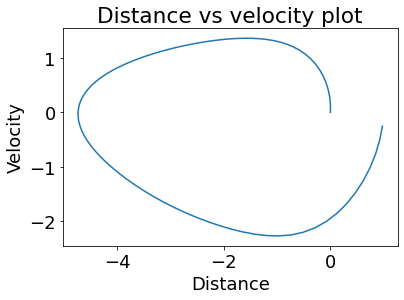

_______________________________________________________________________________________________________________

Iteration number:	 57
loss: 0.000


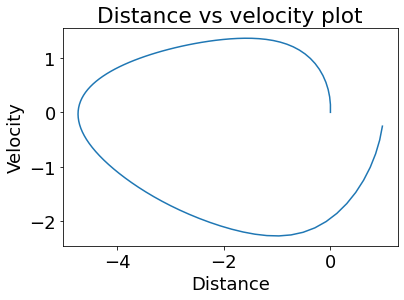

_______________________________________________________________________________________________________________

Iteration number:	 58
loss: 0.000


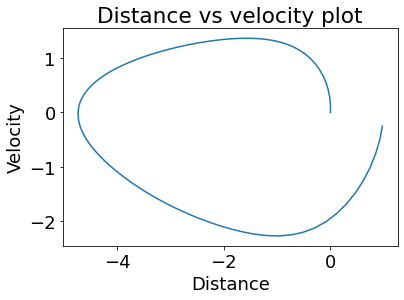

_______________________________________________________________________________________________________________

Iteration number:	 59
loss: 0.000


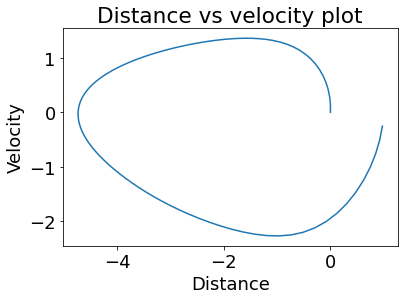

_______________________________________________________________________________________________________________

Iteration number:	 60
loss: 0.000


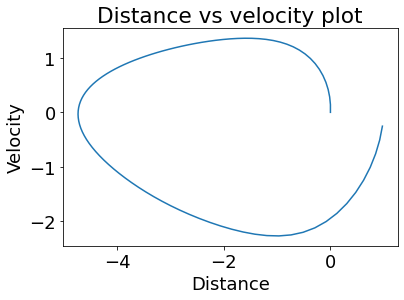

_______________________________________________________________________________________________________________

Iteration number:	 61
loss: 0.000


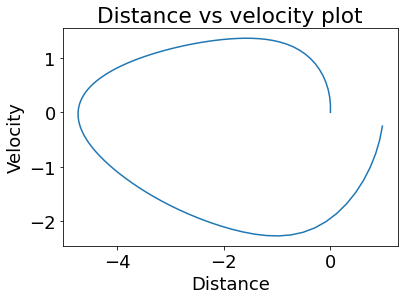

_______________________________________________________________________________________________________________

Iteration number:	 62
loss: 0.000


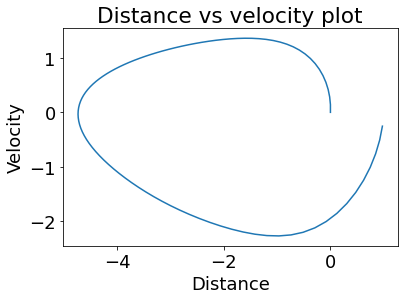

_______________________________________________________________________________________________________________

Iteration number:	 63
loss: 0.000


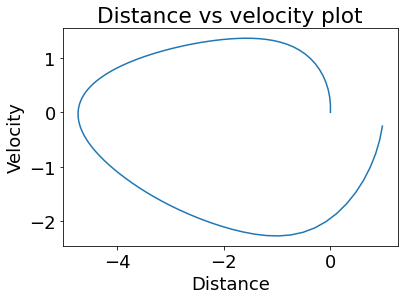

_______________________________________________________________________________________________________________

Iteration number:	 64
loss: 0.000


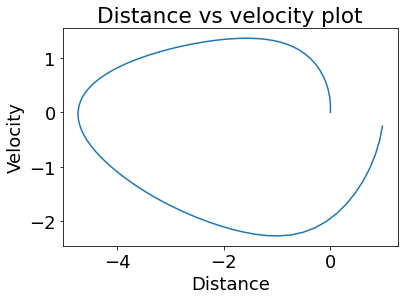

_______________________________________________________________________________________________________________

Iteration number:	 65
loss: 0.000


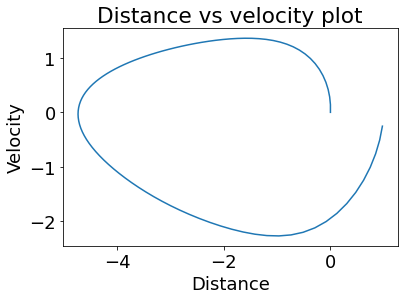

_______________________________________________________________________________________________________________

Iteration number:	 66
loss: 0.000


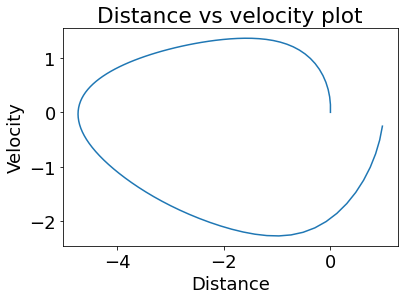

_______________________________________________________________________________________________________________

Iteration number:	 67
loss: 0.000


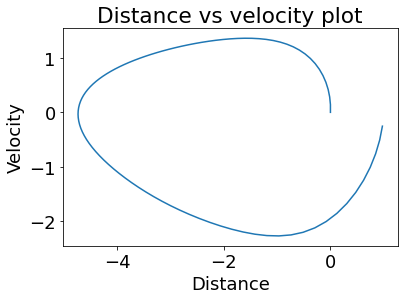

_______________________________________________________________________________________________________________

Iteration number:	 68
loss: 0.000


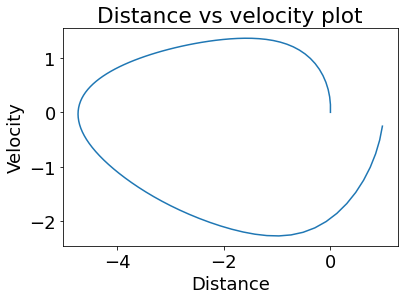

_______________________________________________________________________________________________________________

Iteration number:	 69
loss: 0.000


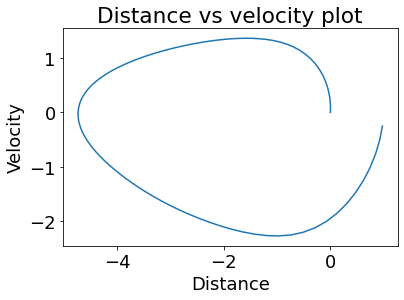

_______________________________________________________________________________________________________________

Iteration number:	 70
loss: 0.000


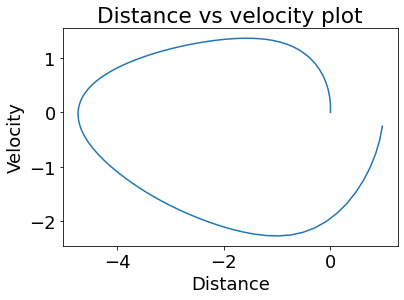

In [32]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 9.81  # m/s2, gravity constant
BOOST_ACCEL = 20.0  # m/s2, thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust in y direction. range (0, 1).
                    0 means no thrust.
                    1 means thrust.
        
        state:
        state[0] = y
        state[1] = v_y
        """
        
        # Apply gravity       
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        # Thrust is calculated
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        temp = delta_state
        
        """"
        The calculation and assumptions of specifiactions of the rocket is as shown below
        
        Drag force: D = Cd * A * .5 * r * V^2
        Cd = 0.3 (Drag co-efficint of cylinder) ref: 
        A = pi * 9 ^2 = 254.47 m^2
        r = 400 kg/m^3 (Density of material)
        V = velocity = delta state
        m = 600000 Kg 
        
        D = 0.3 * 254.47 * 0.5 * 400 * delta_state**2
        
        also applying force balance on the rocket
        
        m * DRAG_DECEL (deceleration due to drag) = D
        DRAG_DECEL = 0.02545 * delta_state**2
        
        """
        #Updating drag
        DRAG_DECEL = 0.02545 * temp * temp
        
        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL # Updating net accel
        
        #Re-calculating new velocity
        delta_state = NET_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        
        # Update velocity and gravity
        state = state + delta_state + delta_state_gravity
        
        # Update state 
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.title('Distance vs velocity plot')
        plt.xlabel('Distance')
        plt.ylabel('Velocity')
        plt.plot(x, y)
        plt.show()

# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(70)  # solve the optimization problem